In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(context="poster", font_scale=1.4)
import glob
import time
import itertools

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

km = 1e5 # cm in km
yr = 3600*24*365.24 # s in yr

In [2]:
prefix = "shock"
# prefix = "equilibrium"

checkpoint_filenames = glob.glob(prefix + "*checkpoint*.dat")
checkpoint_filenames = sorted(checkpoint_filenames)

cols = ["r", "rho", "u", "P"]
plot_label_dict = {"r": r"$r$ [km (reference)]",
                   "rho": r"$\rho$ [g cm$^{-3}$]",
                   "u": r"$u$ [km s$^{-1}$]",
                   "P": r"$P$ [dyne cm$^{-2}$]"}

# y_axis_scaling = {"r": 1e-5, # [km]
#                   "rho": 1,
#                   "u": 1e-5,
#                   "P": 1}

y_log_or_linear = {"r": "linear", # [km]
                  "rho": "log",
                  "u": "linear",
                  "P": "log"}

df= pd.DataFrame()
times = np.empty(len(checkpoint_filenames))
for k, filename in enumerate(checkpoint_filenames):
    f = open(filename)
    times[k] = float(f.readline().split()[2])
    f.close()
    data = np.loadtxt(filename)
    index = pd.MultiIndex.from_product([k, data[:,0]/km], names=["k", "R"])

    df_tmp = pd.DataFrame(data[:,1:], columns=cols, index=index)
    df = pd.concat([df, df_tmp])

#rescale to more appropriate units (cm -> km)
df.r /= km
df.u /= km
# no need to rescale:
# df.rho *= 1
# df.P *= 1
    

max_R = df.index.max()[1]
max_R = df.loc[0].index.max()
    
def plotter(k, variable):
#     ((df.loc[k])[variable] * y_axis_scaling[variable]).plot()
    (df.loc[k])[variable].plot(label="data")

    plt.xlim(xmax=max_R)
    plt.xlabel("R [km]")
    plt.ylabel(plot_label_dict[variable])
    plt.yscale(y_log_or_linear[variable])
    plt.title(r"$t = $ {0:.3} [s]  ({1:.3} [yr])".format(times[k], times[k]/yr))
    plt.axvline(x=10, linestyle="dashed", color="k", label="blast")
    plt.legend(loc="best")
    plt.show()



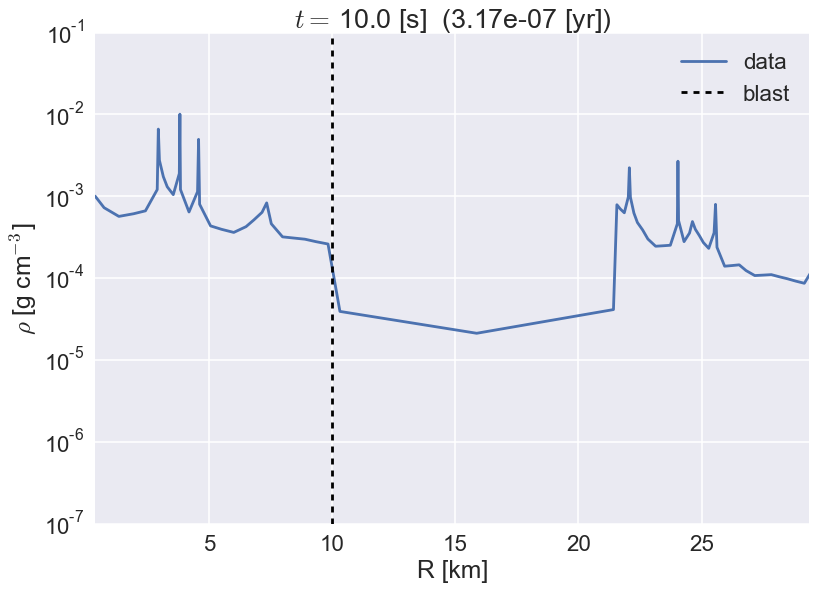

In [3]:
v = interact(plotter, k=widgets.IntSlider(min=0,max=len(checkpoint_filenames)-1), 
                      variable=widgets.Dropdown(options=cols, value="rho"))

def animation():
    slider = v.widget.children[0]
    for i in range(slider.min, slider.max+1):
        slider.value=i
        time.sleep(.1)
        
w = interact_manual(animation)
animation()

In [4]:
if prefix is not "equilibrium":
    raise RuntimeError("Wrong prefix loaded")
with sns.axes_style("ticks"):
    with sns.plotting_context("paper", font_scale=2):
        with sns.color_palette("deep"):
            ks_plot = range(0, len(checkpoint_filenames), 2)
            ks_plot = [0, 1, 10]
            styles=itertools.cycle([":","--","-",":",])
            for k in ks_plot:
                label = "t = {0} sound crossings".format(10*k)
                df.loc[k].rho.plot(label=label, linestyle=next(styles), linewidth=4)
            plt.yscale("log")
            plt.ylabel(r"$\rho$ [g cm$^{-3}$]")
            plt.legend(loc="best")
            plt.xlim(xmax=df.loc[0].index.max())
            plt.tight_layout()
            plt.savefig("equilibrium_evolution.eps")

RuntimeError: Wrong prefix loaded

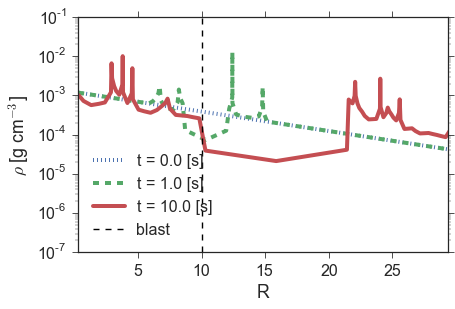

In [5]:
if prefix is not "shock":
    raise RuntimeError("Wrong prefix loaded")
with sns.axes_style("ticks"):
    with sns.plotting_context("paper", font_scale=2):
        with sns.color_palette("deep"):
            ks_plot = range(0, len(checkpoint_filenames), 2)
            ks_plot = [0, 1, 10]
            styles=itertools.cycle([":","--","-",":",])
            for k in ks_plot:
                df.loc[k].rho.plot(label="t = {0:0.3} [s]".format(times[k]), linestyle=next(styles), linewidth=4)
            plt.yscale("log")
            plt.ylabel(r"$\rho$ [g cm$^{-3}$]")
            plt.axvline(x=10, linestyle="dashed", color='k', label="blast")
            plt.legend(loc="best")
            plt.xlim(xmax=df.loc[0].index.max())
            plt.tight_layout()
            plt.savefig("shock_evolution.eps")


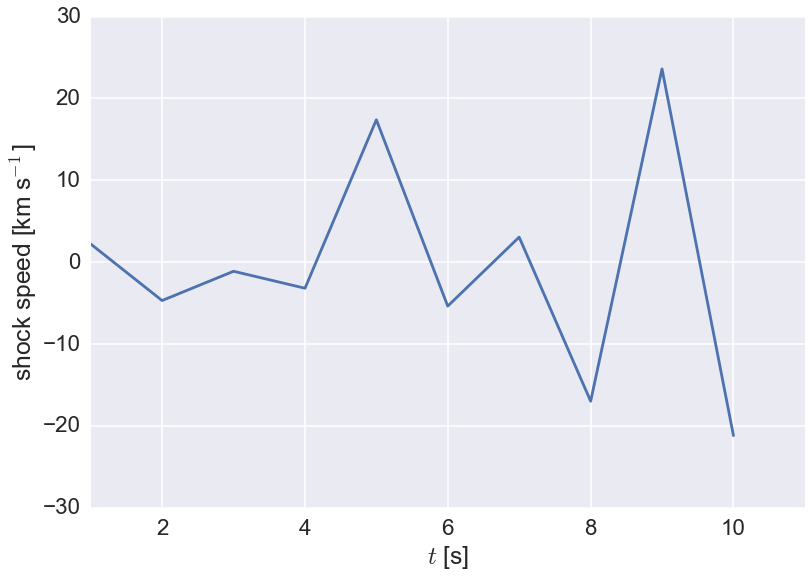

In [6]:
spike_loc = [df.loc[k].P.argmax() for k in range(len(checkpoint_filenames))]
spike_speed = [(spike_loc[k+1]-spike_loc[k]) / (times[k+1] - times[k]) for k in range(len(checkpoint_filenames)-1)]
plt.plot(times[1:], spike_speed)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"shock speed [km s$^{-1}$]")